In [ ]:
# Dataset Link
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight


2025-11-03 23:45:05.777660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762213505.966476      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762213506.019901      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load Dataset
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
df = df[['Text', 'Score']].dropna()
df = df.head(50_000)
df

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5
...,...,...
49995,My sister introduced me to these. They have be...,5
49996,A friend recommended these bars and I fell in ...,5
49997,Fabulous! I take one to work with me every da...,5
49998,I love these bars and will continue to buy the...,4


In [3]:
df = df[df['Score'] != 3]

In [4]:
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

/tmp/ipykernel_37/1804926074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)


In [5]:
df.reset_index(drop=True, inplace= True)
df

,Text,Score,Sentiment
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1
...,...,...,...
45948,My sister introduced me to these. They have be...,5,1
45949,A friend recommended these bars and I fell in ...,5,1
45950,Fabulous! I take one to work with me every da...,5,1
45951,I love these bars and will continue to buy the...,4,1


In [6]:
x = df['Text']
y = df['Sentiment']

In [7]:
# Split Data

# Train (70%)  Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42, stratify= y) 

# Validation (15%)  Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,stratify= y_temp)

print(len(X_train))
print(len(X_val))
print(len(X_test))


32167
6893
6893


In [8]:
# Convert Numpy arrays to tf Dataset
tf.random.set_seed(42)


train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).shuffle(10000, seed=42).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values)).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(32).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1762213524.848167      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [9]:
for X_batch, y_batch in train_ds.take(1):
    print(f"X shape: {X_batch.shape}")
    print(f"y shape: {y_batch.shape}")

X shape: (32,)
y shape: (32,)


In [10]:
for X_batch, y_batch in train_ds.take(1):
    print(X_batch.numpy()[:10])
    print(y_batch.numpy()[:10])

[b"This product works, it doesn't taste the best BUT, it works! No more leg cramps! That out ways taste any day!"
 b"Ordering my coffee from Amazon is so easy and postage free.  I don't know how they do it but when my box is getting low here comes an offer on my e-mail.  I could buy it at my local grocery for a penny more but the convenience of having coffee delivered to my front door is worth the penny it cost. I don't have to walk in the snow or drive my car for $4.00 per gallon.  Thank you Uncle Amazon"
 b'I first tried Britt dark roast when I was In Costa Rica.  It has a lot of rich flavor, but it is not bitter at all.  I\'ve bought<br />it by the case ever since.  It\'s really no more expensive than those "gourmet" brands you find at your local store.  This is<br />simply the best coffee I\'ve ever had, and I\'ve tried many supposedly special ones over the years.'
 b'I have tried original, BBQ and salt and vinegar. They all they good, the BBQ is the most flavorful. The salt and vi

In [11]:
# Handle Imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: 3.049582859309822, 1: 0.5980552560145763}


In [12]:
# Text Vectorization Layer
max_tokens = 1000  
max_len = 50     

tokenizer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len
)

tokenizer.adapt(X_train.values)


In [13]:
token_ids = tokenizer('My favorite food is pasta')
token_ids

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([ 13, 142,  59,   9, 514,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])>

In [14]:
# Decoding
def decode_to_text(token_ids, tokenizer):
    text = ''
    for idx in token_ids:
        text = text + f" {tokenizer.get_vocabulary()[idx]}"
    text = text.strip()
    return text

decode_to_text(token_ids, tokenizer)

'my favorite food is pasta'

In [15]:
# Build Model
input_ = Input(shape=(), dtype=tf.string, name='text_input')
hidden = tokenizer(input_)
hidden = Embedding(max_tokens , 128, mask_zero=True, name='embedding')(hidden)
hidden = Bidirectional(LSTM(128, activation="tanh", kernel_initializer="glorot_uniform", recurrent_dropout=0.3))(hidden)
hidden = Dense(64, activation='relu')(hidden)
output = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(hidden)

model = Model(input_, output, name='LSTM_Sentiment_Model')

model.summary()


Model: "LSTM_Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 50)        │          0 │ text_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │    128,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ text_vectorizati… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 407,681 (1.56 MB)

 Trainable params: 407,681 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=5, class_weight=class_weights)

Epoch 1/5
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 220s 208ms/step - accuracy: 0.7123 - loss: 0.5288 - val_accuracy: 0.8026 - val_loss: 0.4093
Epoch 2/5
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 207s 206ms/step - accuracy: 0.8021 - loss: 0.3937 - val_accuracy: 0.8011 - val_loss: 0.4261
Epoch 3/5
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 208s 207ms/step - accuracy: 0.8409 - loss: 0.3357 - val_accuracy: 0.8185 - val_loss: 0.3779
Epoch 4/5
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 207s 206ms/step - accuracy: 0.8545 - loss: 0.3028 - val_accuracy: 0.8355 - val_loss: 0.3455
Epoch 5/5
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 208s 207ms/step - accuracy: 0.8679 - loss: 0.2686 - val_accuracy: 0.7912 - val_loss: 0.4367


In [17]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8147 - loss: 0.3939
Test Accuracy: 0.8024, Test Loss: 0.4202


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred_labels))

216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step
              precision    recall  f1-score   support

           0       0.43      0.89      0.58      1130
           1       0.97      0.77      0.86      5763

    accuracy                           0.79      6893
   macro avg       0.70      0.83      0.72      6893
weighted avg       0.88      0.79      0.82      6893



In [19]:
import tensorflow_hub as hub
class USE_Embedding(tf.keras.layers.Layer):

    def __init__(self, link, trainable):
        super().__init__()
        self.embedding_layer = hub.KerasLayer(link, trainable=trainable)
        
    def call(self, inputs):
        return self.embedding_layer(inputs)

In [20]:
# transfer Learning usning Universal Sentence Encoder (USE)
trainable = False
use_layer = USE_Embedding("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=trainable)
use_layer

<USE_Embedding name=use__embedding, built=False>

In [21]:
# Build Model
input_ = Input(shape=(), dtype=tf.string, name='text_input')
hidden = use_layer(input_)
hidden = Dropout(0.2)(hidden)
hidden = Dense(128, activation='relu')(hidden)
hidden = Dense(64, activation='relu')(hidden)
output = Dense(1, activation='sigmoid', name='output')(hidden)

USE_Sentiment_Model = Model(inputs=input_, outputs=output, name='USE_Sentiment_Model')

USE_Sentiment_Model.summary()

Model: "USE_Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use__embedding (USE_Embedding)  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,985 (289.00 KB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
USE_Sentiment_Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],run_eagerly=True)

history = USE_Sentiment_Model.fit(train_ds, validation_data=val_ds, epochs=10, class_weight=class_weights)


Epoch 1/10
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.8351 - loss: 0.4172 - val_accuracy: 0.8017 - val_loss: 0.4384
Epoch 2/10
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 76s 76ms/step - accuracy: 0.8481 - loss: 0.3286 - val_accuracy: 0.8780 - val_loss: 0.2753
Epoch 3/10
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 78s 77ms/step - accuracy: 0.8603 - loss: 0.3045 - val_accuracy: 0.8620 - val_loss: 0.3068
Epoch 4/10
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 78s 78ms/step - accuracy: 0.8748 - loss: 0.2771 - val_accuracy: 0.8543 - val_loss: 0.3226
Epoch 5/10
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 76s 76ms/step - accuracy: 0.8821 - loss: 0.2637 - val_accuracy: 0.8806 - val_loss: 0.2676
Epoch 6/10
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 76s 75ms/step - accuracy: 0.8898 - loss: 0.2476 - val_accuracy: 0.8773 - val_loss: 0.2812
Epoch 7/10
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 76s 75ms/step - accuracy: 0.8963 - loss: 0.2332 - val_accuracy: 0.8648 - val_loss: 0.3071
Epoch 8/10
1006/1006 ━━━━━━━━━━━━━━━━━━━━ 76s 75ms/step - accuracy: 0.9010 -

In [23]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = USE_Sentiment_Model.predict(val_ds)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred_labels))

216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      1130
           1       0.97      0.91      0.94      5763

    accuracy                           0.90      6893
   macro avg       0.80      0.87      0.83      6893
weighted avg       0.91      0.90      0.90      6893



In [24]:
test_loss, test_acc = USE_Sentiment_Model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


216/216 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8962 - loss: 0.2557
Test Accuracy: 0.8977, Test Loss: 0.2498


In [25]:
# FineTuning
# use_layer = USE_Embedding("https://tfhub.dev/google/universal-sentence-encoder-large/5", trainable=True)


In [26]:
# # Build Model
# input_ = Input(shape=(), dtype=tf.string, name='text_input')
# hidden = use_layer(input_)
# # hidden = Dropout(0.3)(hidden)
# hidden = Dense(128, activation='relu')(hidden)
# hidden = Dense(64, activation='relu')(hidden)
# output = Dense(1, activation='sigmoid', name='output')(hidden)

# USE_Sentiment_Model_1 = Model(inputs=input_, outputs=output, name='USE_Sentiment_Model')

# USE_Sentiment_Model_1.summary()

In [27]:
# from tensorflow.keras.optimizers import Adam
# optimizer = Adam(learning_rate=1e-4)
# USE_Sentiment_Model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'],run_eagerly=True)

# history = USE_Sentiment_Model_1.fit(train_ds, validation_data=val_ds, epochs=5)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = USE_Sentiment_Model.predict(val_ds)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred_labels))


216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      1130
           1       0.97      0.91      0.94      5763

    accuracy                           0.90      6893
   macro avg       0.80      0.87      0.83      6893
weighted avg       0.91      0.90      0.90      6893



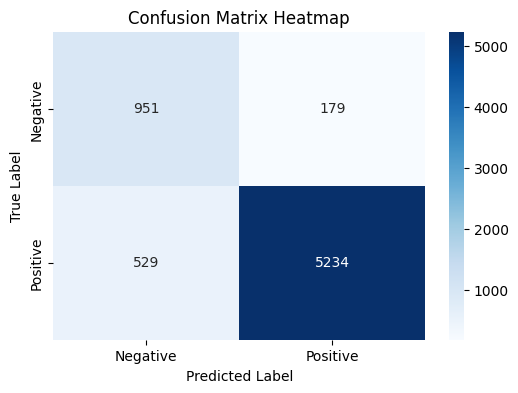

In [29]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [30]:
# Highest Error Class & Instance -
errors = np.where(y_true != y_pred_labels)[0]
num_errors = len(errors)
total = len(y_true)

print(f"Total errors: {num_errors} / {total} ({num_errors/total:.2%})")

cm_df = sns.heatmap(cm, annot=True, fmt='d')
plt.close()
false_neg = cm[1][0]
false_pos = cm[0][1]

if false_pos > false_neg:
    highest_error_class = 'Negative misclassified as Positive'
else:
    highest_error_class = 'Positive misclassified as Negative'

print(f"Highest error class: {highest_error_class}")

if num_errors > 0:
    print("\nExample of misclassified instance:")
    val_texts = np.concatenate([x.numpy() for x, y in val_ds])
    idx = errors[0]
    print(f"Text: {val_texts[idx]}")
    print(f"True Label: {y_true[idx]}, Predicted: {y_pred_labels[idx]} (Prob={y_pred[idx][0]:.2f})")
else:
    print("No misclassified instances found.")

Total errors: 708 / 6893 (10.27%)
Highest error class: Positive misclassified as Negative

Example of misclassified instance:
Text: b"Ok, so I have ordered the 1 oz and 1/2 oz bags and absolutely love them!! They definitely have a cheesy flavor and are delicious. I decided to order the 4 oz bags because it is more oz for your money. They aren't good at all! They have NO cheese flavor at all. I am very disappointed with this! I have contacted the company to see what they say about it and will update my review once I get a response. Don't buy the 4 oz. bags!!!<br />Update**I contacted the company and they did send me a brand new box. It was much better! Apparently the 1st box I got was old!"
True Label: 1, Predicted: 0 (Prob=0.12)


In [31]:
samples = [
    "This phone is really good and fast!",
    "The product quality is terrible.",
    "This Food is Not Good"
]

samples_tensor = tf.constant(samples)

preds = model.predict(samples_tensor)
for text, p in zip(samples, preds):
    print(f"{text} → {'Positive' if p > 0.5 else 'Negative'} ({p[0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
This phone is really good and fast! → Positive (1.00)
The product quality is terrible. → Negative (0.00)
This Food is Not Good → Negative (0.02)


In [32]:
USE_Sentiment_Model.save("sentiment_model.h5")

In [33]:
class USE_Embedding(tf.keras.layers.Layer):
    def __init__(self, link, trainable, **kwargs):
        super().__init__(**kwargs)
        self.embedding_layer = hub.KerasLayer(link, trainable=trainable)
    def call(self, inputs):
        return self.embedding_layer(inputs)



loaded_model = tf.keras.models.load_model(
    "sentiment_model.h5",
    custom_objects={
        'USE_Embedding': USE_Embedding,
        'KerasLayer': hub.KerasLayer
    }
)


In [34]:
loaded_model.summary()

Model: "USE_Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)         │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use__embedding_1                │ (None, 512)            │             0 │
│ (USE_Embedding)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,987 (289.02 KB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [38]:
samples = [
    "This phone is really good and fast!",
    "The product quality is terrible.",
    "Excellent service and very kind staff."
]

samples_tensor = tf.constant(samples)

preds = loaded_model.predict(samples_tensor)

for text, p in zip(samples, preds):
    sentiment = "Positive" if p > 0.5 else "Negative"
    print(f"{text} → {sentiment} ({p[0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This phone is really good and fast! → Positive (1.00)
The product quality is terrible. → Negative (0.11)
Excellent service and very kind staff. → Positive (0.99)
